In [65]:
'''不将训练集划分为验证集，直接利用整体训练集训练的模型测试在测试集上的效果'''
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda 0' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [66]:
filepath = "train_all.csv"
train_data = pd.read_csv(filepath)
test_data = pd.read_csv("test.csv")

In [67]:
'''将train.csv and test.csv 中的数据转化为np.array，按照原格式111*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

In [68]:
def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

In [69]:
'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 111, 735)
#print(train_data_rows[0])
test_data_rows = loaddata(test_data, 111, 56)
type(test_data_rows)

numpy.ndarray

In [70]:
'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
test_data_rows_nor = normalizationdata(test_data_rows)
#test_data_rows_nor[0]

In [71]:
'''根据不同的输入步长num_row，将分割出来的数据放入到data_rows中
data_rows=[训练数据(num_row)，训练数据的验证(长度为56)]
输入的数据为归一化处理过后的训练集，以及输入步长'''
def input_size(data_nor, num_row):#输出为定长56，而输入长度可以改变，为num_rows
    train_data_rows = []
    test_data_rows = []

    for row in range(0,111):
        train_data_row = []
        test_data_row = []
        for line in range(0,735):
            count=line
            data_row_train = []
            data_row_test = []

            if line + num_row + 56 - 1 == 735: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                break

            while True:
                if count  < line+num_row:
                    data_row_train.append(data_nor[row][count]) #将每一行的各列的数据放入data_row_train中
                    count += 1

                elif count >= line+num_row and count<line+num_row+56:#如果count大于等于输入步长且小于输入加输出步长，则输入到data_row_test中
                    data_row_test.append(data_nor[row][count])
                    count += 1
                
                elif count == line+num_row+56: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                    break

            train_data_row.append(data_row_train)
            test_data_row.append(data_row_test)

        train_data_rows.append(train_data_row)
        test_data_rows.append(test_data_row)

    return np.array(train_data_rows), np.array(test_data_rows)
    

In [72]:
'''得到不同输入步长的训练集合,training_data_input_x的维度为(行数（111），每一行划分成了多少个训练样本/测试样本集合，输入步长)'''
training_data_input_56, train_data_output_56 = input_size(train_data_rows_nor, 56)
print(training_data_input_56.shape)
print(train_data_output_56.shape)

training_data_input_112, train_data_output_112 = input_size(train_data_rows_nor, 112)
print(training_data_input_112.shape)
print(train_data_output_112.shape)

training_data_input_679, train_data_output_679 = input_size(train_data_rows_nor, 679)
print(training_data_input_679.shape)
print(train_data_output_679.shape)

(111, 624, 56)
(111, 624, 56)
(111, 568, 112)
(111, 568, 56)
(111, 1, 679)
(111, 1, 56)


In [73]:
'''pytorch搭建mlp模型'''
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=679):    #输入步长默认为679
        super(NeuralNetwork,self).__init__()
        self.input_size = input_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,56)
        )
    #forward和init函数要对齐，否则报错NotImplementedError
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [74]:
'''测试模型'''
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=679, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=56, bias=True)
  )
)


In [75]:
'''将数据转化为tensor'''
input_56, output_56 = torch.tensor(training_data_input_56), torch.tensor(train_data_output_56)
input_112, output_112 = torch.tensor(training_data_input_112), torch.tensor(train_data_output_112)
input_679, output_679 = torch.tensor(training_data_input_679), torch.tensor(train_data_output_679)


In [76]:
'''观察转化后维度是否一致'''
print(input_56.shape[1])
print(output_56.shape)
print(input_112.shape)
print(output_112.shape)
print(input_679.shape)
print(output_679.shape)

624
torch.Size([111, 624, 56])
torch.Size([111, 568, 112])
torch.Size([111, 568, 56])
torch.Size([111, 1, 679])
torch.Size([111, 1, 56])


In [77]:
'''初始化模型，定义损失函数和优化方法'''
model_56 = NeuralNetwork(56).to(device)
model_112 = NeuralNetwork(112).to(device)
model_679 = NeuralNetwork(679).to(device)

loss_MSE = nn.MSELoss()#定义损失函数MSE
loss_MAE = nn.L1Loss()#定义损失函数MAE

optimizer_56 = torch.optim.SGD(model_56.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()
optimizer_112 = torch.optim.SGD(model_112.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()
optimizer_679 = torch.optim.SGD(model_679.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

In [78]:
'''训练函数,输入为input_xx和output_xx,输入步长等'''
def train(X_datas, y_datas, input_size, model, loss_def, optimizer, epochs):
    rows = X_datas.shape[0]
    nums = X_datas.shape[1]
    model.train() #启用batch normalization和drop out,如果有

    losses = []
    iterations = []

    for epoch in range(epochs):
        for row in range(rows):  
            num = 0
            while num<nums:
                X = X_datas[row][num]
                y = y_datas[row][num]
                X, y = X.to(device), y.to(device)

                num += input_size+56  #不对重复的数据进行迭代训练

                pred = model(X)#预测值
                loss = loss_def(pred, y)#损失计算

                optimizer.zero_grad()#后向传播
                loss.backward()
                optimizer.step()

                loss = loss.item()

        if epoch%50 == 0:
            print("the loss of epoch "+ str(epoch) + " is: " + str(loss))
            losses.append(loss)
            iterations.append(epoch)

    prediction = model(X_datas.to(device))

    plt.figure()
    plt.title("loss of epochs per 50————————the input size: "+str(input_size)+"    the loss is: " + str(loss_def))
    plt.xlabel("epoch per 50")
    plt.ylabel("loss")
    plt.plot(iterations,losses)
    
    plt.show()

    return prediction.to('cpu')

In [79]:
'''sMAPE精确度指标'''
def sMAPE(pred, y):
    n = pred.shape[0] * pred.shape[1]  #各个维度相乘，计算一共有多少个元素   （111*56个元素）
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100

In [80]:
'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

In [81]:
'''计算不同输入步长的sMAPE指标，输入有归一化后的训练集数据和测试集数据,以及未归一化的训练集数据和测试数据，以及输入步长和模型
步骤：将初始归一化后的数据转化为tesor -> 利用模型输入训练集倒数的输入步长得到预测值 -> 求出未正则化数据的最大值最小值 -> 进行反归一化 -> 利用预测值和测试集计算sMAPE值'''
def cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, input_size, model):
    training_data = torch.tensor(train_data_rows_nor)#将归一化的测试数据转化为tensor
    testing_data = torch.tensor(test_data_rows_nor) #将归一化的测试数据转化为tensor

    training_data_input = training_data[:,[range(735-input_size,735)]]  #要输入的训练集中后输入长度个个数据,用于预测test集
    training_data_input = training_data_input.squeeze()

    prediction = model(training_data_input.to(torch.float32).to(device)) #用训练集后输入长度个数据得到的预测值
    #print(pred.shape)
    
    #训练集数据最大值最小值
    train_max = np.max(train_data_rows, axis = 1) #找每行最大的，默认每axis为0，即每列
    train_min = np.min(train_data_rows, axis = 1)
    train_max = torch.tensor(train_max).view(training_data.shape[0],1) #torch.tensor消除了最后的1的维度，因此要用view恢复为(111,1)的形状
    train_min = torch.tensor(train_min).view(training_data.shape[0],1)

    #测试集数据最大值最小值
    test_max = np.max(test_data_rows, axis = 1)
    test_min = np.min(test_data_rows, axis = 1)
    test_max = torch.tensor(test_max).view(training_data.shape[0],1)
    test_min = torch.tensor(test_min).view(training_data.shape[0],1)
    
    pred = reverse_normalizationdata(prediction, train_max, train_min)   #pred代表训练集归一化后带入训练过的模型输出的预测值。并且用训练集的最大最小值进行反归一化
    y = reverse_normalizationdata(testing_data, test_max, test_min)   #y代表真实的测试数据利用测试数据的最大最小值进行反归一化

    acc = sMAPE(pred, y)

    print("输入步长为"+str(input_size)+"的sMAPE指标："+str(acc.item())) #item可以只保留数字

    return acc

In [82]:
'''同样的训练过程，不过绘制出随着epoch的增加，输入训练集的倒数的输入步长与测试数据的sMAPE值变化
训练函数,输入为input_xx和output_xx,输入步长,以及cal_sMAPE的输入参数'''
def train_sMAPE(X_datas_train, y_datas_train, train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, input_size, model, loss_def, optimizer, epochs):
    rows = X_datas_train.shape[0]
    nums = X_datas_train.shape[1]
    model.train() #启用batch normalization和drop out,如果有

    #losses = []
    iterations = []
    sMAPEs = []

    for epoch in range(epochs):
        for row in range(rows):  
            num = 0
            while num<nums:
                X = X_datas_train[row][num]
                y = y_datas_train[row][num]
                X, y = X.to(device), y.to(device)

                num += input_size+56  #不对重复的数据进行迭代训练

                pred = model(X)#预测值
                loss = loss_def(pred, y)#损失计算

                optimizer.zero_grad()#后向传播
                loss.backward()
                optimizer.step()

                #loss = loss.item()
                sMAPE = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, input_size, model).detach().numpy()

        if epoch%100 == 0:
            print("the sMAPE of epoch "+ str(epoch) + " is: " + str(sMAPE))
            sMAPEs.append(sMAPE)
            #losses.append(loss)
            iterations.append(epoch)

    plt.figure() #再次输入可新建画布
    plt.title("loss of epochs per 100————————输入步长："+str(input_size))
    plt.xlabel("epoch per 100")
    plt.ylabel("sMAPE")
    plt.plot(iterations,sMAPEs)
    
    plt.show()


In [83]:
'''Adam优化
torch.optim.Adam(model_56.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)
torch.optim.Adam(model_112.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)
torch.optim.Adam(model_679.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)
'''

'Adam优化\ntorch.optim.Adam(model_56.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)\ntorch.optim.Adam(model_112.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)\ntorch.optim.Adam(model_679.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)\n'

the loss of epoch 0 is: 0.047807931900024414
the loss of epoch 50 is: 0.0040286569856107235
the loss of epoch 100 is: 0.0039885095320641994
the loss of epoch 150 is: 0.004010496195405722
the loss of epoch 200 is: 0.0039827702566981316
the loss of epoch 250 is: 0.003949700389057398
the loss of epoch 300 is: 0.00390701275318861
the loss of epoch 350 is: 0.0038682110607624054
the loss of epoch 400 is: 0.003838546108454466
the loss of epoch 450 is: 0.0038128900341689587


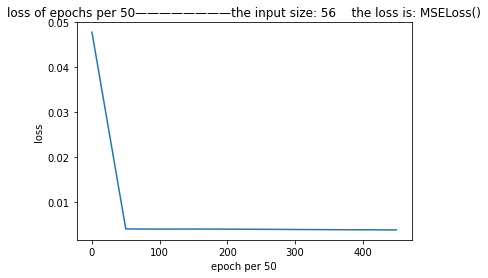

输入步长为56的sMAPE指标：38.478948197026625


In [87]:
'''输入步长为56,损失函数为MSE，SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_56_mse_sgd = NeuralNetwork(56).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_56 = torch.optim.SGD(model_56_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_56.to(torch.float32), output_56.to(torch.float32), 56, model_56_mse_sgd, loss_MSE, optimizer_56, 500)
'''计算sMAPE指标并输出'''
acc_56 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56_mse_sgd)

the loss of epoch 0 is: 0.16455350816249847
the loss of epoch 50 is: 0.04664061218500137
the loss of epoch 100 is: 0.04606498032808304
the loss of epoch 150 is: 0.04617605730891228
the loss of epoch 200 is: 0.046463172882795334
the loss of epoch 250 is: 0.046655766665935516
the loss of epoch 300 is: 0.046727266162633896
the loss of epoch 350 is: 0.046734265983104706
the loss of epoch 400 is: 0.04665622487664223
the loss of epoch 450 is: 0.046599265187978745


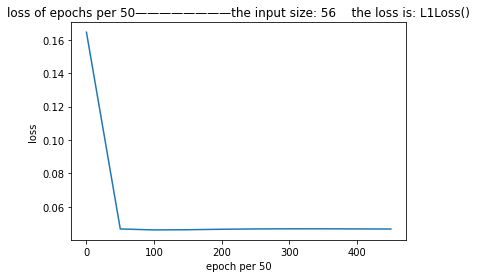

输入步长为56的sMAPE指标：39.30224737495581


In [88]:
'''输入步长为56,损失函数为MAE，SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_56_mae_sgd = NeuralNetwork(56).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MAE
optimizer_56 = torch.optim.SGD(model_56_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_56.to(torch.float32), output_56.to(torch.float32), 56, model_56_mae_sgd, loss_MAE, optimizer_56, 500)

acc_56 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56_mae_sgd)

the loss of epoch 0 is: 0.0041062007658183575
the loss of epoch 50 is: 0.0017841086955741048
the loss of epoch 100 is: 0.0017697600414976478
the loss of epoch 150 is: 0.0018081777961924672
the loss of epoch 200 is: 0.0014073305064812303
the loss of epoch 250 is: 0.0014929539756849408


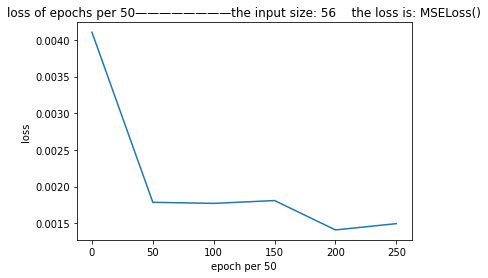

输入步长为56的sMAPE指标：45.492630657661984


In [89]:
'''输入步长为56,损失函数为MSE，Adam优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_56_mse_adam = NeuralNetwork(56).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_56 = torch.optim.Adam(model_56_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_56.to(torch.float32), output_56.to(torch.float32), 56, model_56_mse_adam, loss_MSE, optimizer_56, 300)
'''计算sMAPE指标并输出'''
acc_56 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56_mse_adam)

the loss of epoch 0 is: 0.03216303139925003
the loss of epoch 50 is: 0.005419472698122263
the loss of epoch 100 is: 0.003536340082064271
the loss of epoch 150 is: 0.0035427939146757126
the loss of epoch 200 is: 0.0035648311022669077
the loss of epoch 250 is: 0.0035551826003938913
the loss of epoch 300 is: 0.0035346541553735733
the loss of epoch 350 is: 0.00351219205185771
the loss of epoch 400 is: 0.0034904612693935633
the loss of epoch 450 is: 0.0034698897507041693


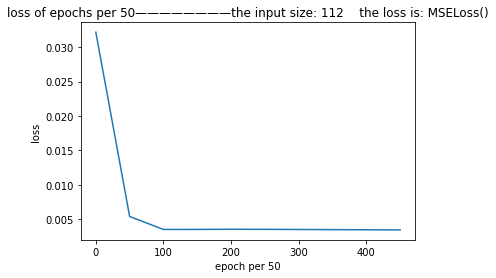

输入步长为112的sMAPE指标：39.145918215275486


In [90]:
'''输入步长为112，损失函数为MSE，SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_112_mse_sgd = NeuralNetwork(112).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_112 = torch.optim.SGD(model_112_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_112.to(torch.float32), output_112.to(torch.float32), 112, model_112_mse_sgd, loss_MSE, optimizer_112, 500)

acc_112 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112_mse_sgd)

the loss of epoch 0 is: 0.1587599664926529
the loss of epoch 50 is: 0.0468074269592762
the loss of epoch 100 is: 0.046444427222013474
the loss of epoch 150 is: 0.0459628626704216
the loss of epoch 200 is: 0.04589713737368584
the loss of epoch 250 is: 0.04587681218981743
the loss of epoch 300 is: 0.04607575759291649
the loss of epoch 350 is: 0.04616842418909073
the loss of epoch 400 is: 0.046313464641571045
the loss of epoch 450 is: 0.04635204002261162


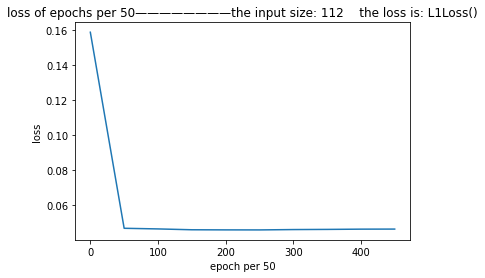

输入步长为112的sMAPE指标：40.598911804961595


In [91]:
'''输入步长为112情况，损失函数为MAE， SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_112_mae_sgd = NeuralNetwork(112).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MAE
optimizer_112 = torch.optim.SGD(model_112_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_112.to(torch.float32), output_112.to(torch.float32), 112, model_112_mae_sgd, loss_MAE, optimizer_112, 500)

acc_112 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112_mae_sgd)

the loss of epoch 0 is: 0.003227532608434558
the loss of epoch 50 is: 0.0016171665629372
the loss of epoch 100 is: 0.0015158074675127864
the loss of epoch 150 is: 0.0015466207405552268
the loss of epoch 200 is: 0.001508840243332088
the loss of epoch 250 is: 0.001713055418804288


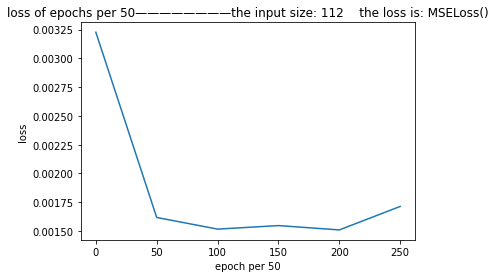

输入步长为112的sMAPE指标：48.79964595996812


In [92]:
'''输入步长为112，损失函数为MSE，Adam优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_112_mse_adam = NeuralNetwork(112).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_112 = torch.optim.Adam(model_112_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_112.to(torch.float32), output_112.to(torch.float32), 112, model_112_mse_adam, loss_MSE, optimizer_112, 300)

acc_112 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112_mse_adam)

the loss of epoch 0 is: 0.03826823830604553
the loss of epoch 50 is: 0.015093171037733555
the loss of epoch 100 is: 0.005232295487076044
the loss of epoch 150 is: 0.0020511294715106487
the loss of epoch 200 is: 0.0012061722809448838
the loss of epoch 250 is: 0.001008015708066523
the loss of epoch 300 is: 0.0009683906682766974
the loss of epoch 350 is: 0.0009619328193366528
the loss of epoch 400 is: 0.0009605857194401324
the loss of epoch 450 is: 0.0009589380933903158


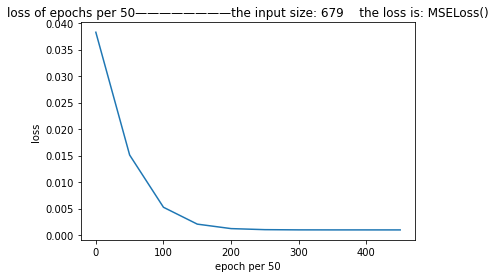

输入步长为679的sMAPE指标：41.407385804027456


In [93]:
'''输入步长为679，损失函数为MSE， SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_679_mse_sgd = NeuralNetwork(679).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_679 = torch.optim.SGD(model_679_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_679.to(torch.float32), output_679.to(torch.float32), 679, model_679_mse_sgd, loss_MSE, optimizer_679, 500)

acc_679 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679_mse_sgd)

the loss of epoch 0 is: 0.17292523384094238
the loss of epoch 50 is: 0.0420166477560997
the loss of epoch 100 is: 0.020659063011407852
the loss of epoch 150 is: 0.02041599340736866
the loss of epoch 200 is: 0.019719522446393967
the loss of epoch 250 is: 0.019176065921783447
the loss of epoch 300 is: 0.018895165994763374
the loss of epoch 350 is: 0.018574131652712822
the loss of epoch 400 is: 0.018458839505910873
the loss of epoch 450 is: 0.01824762485921383


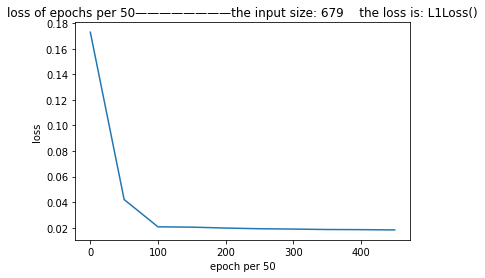

输入步长为679的sMAPE指标：40.98956137665063


In [94]:
'''输入步长为679，损失函数为MAE， SGD优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_679_mae_sgd = NeuralNetwork(679).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MAE
optimizer_679 = torch.optim.SGD(model_679_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_679.to(torch.float32), output_679.to(torch.float32), 679, model_679_mae_sgd, loss_MAE, optimizer_679, 500)

acc_679 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679_mae_sgd)

the loss of epoch 0 is: 0.0010074671590700746
the loss of epoch 50 is: 0.0009269873844459653
the loss of epoch 100 is: 0.001061938819475472
the loss of epoch 150 is: 0.00046131067210808396
the loss of epoch 200 is: 0.0007131975726224482
the loss of epoch 250 is: 0.00062368850922212


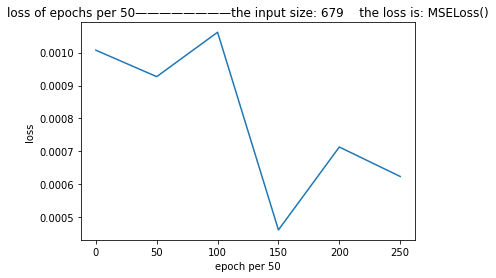

输入步长为679的sMAPE指标：37.21683807578309


In [95]:
'''输入步长为679，损失函数为MSE， Adam优化：
以损失函数作为标准进行训练并绘制图像,并返回预测值'''
'''初始化模型，定义损失函数和优化方法'''
model_679_mse_adam = NeuralNetwork(679).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_679 = torch.optim.Adam(model_679_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(input_679.to(torch.float32), output_679.to(torch.float32), 679, model_679_mse_adam, loss_MSE, optimizer_679, 300)

acc_679 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679_mse_adam)

In [96]:
'''计算sMAPE指标，输出结果
acc_56 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56)
acc_112 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112)
acc_679 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679)
'''


'计算sMAPE指标，输出结果\nacc_56 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56)\nacc_112 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112)\nacc_679 = cal_sMAPE(train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679)\n'

In [97]:
'''利用未训练模型来计算sMAPE，来验证训练后的模型有效性'''
training_data = torch.tensor(train_data_rows_nor)#将归一化的测试数据转化为tensor
x = training_data[:,[range(56,735)]]  
x = x.squeeze()

model = NeuralNetwork().to(device)
prediction= model(x.to(torch.float32).to(device))

train_max = np.max(train_data_rows)
train_min = np.min(train_data_rows)
train_max = torch.tensor(train_max)
train_min = torch.tensor(train_min)
pred = reverse_normalizationdata(prediction, train_max, train_min)

y = torch.tensor(test_data_rows)

acc = sMAPE(pred, y)
print("未经过训练模型计算出的sMAPE指标："+str(acc.item())) 

未经过训练模型计算出的sMAPE指标：1537.8900452369003


In [98]:
'''重新初始化模型，重新开始训练
model_56 = NeuralNetwork(56).to(device)
model_112 = NeuralNetwork(112).to(device)
model_679 = NeuralNetwork(679).to(device)
'''

'重新初始化模型，重新开始训练\nmodel_56 = NeuralNetwork(56).to(device)\nmodel_112 = NeuralNetwork(112).to(device)\nmodel_679 = NeuralNetwork(679).to(device)\n'

In [99]:
'''输入步长为56的基于sMAPE指标的训练绘图
train_sMAPE(input_56.to(torch.float32), output_56.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56, loss_MSE, optimizer_56, 500)
'''

'输入步长为56的基于sMAPE指标的训练绘图\ntrain_sMAPE(input_56.to(torch.float32), output_56.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 56, model_56, loss_MSE, optimizer_56, 500)\n'

In [100]:
'''输入步长为112的基于sMAPE指标的训练绘图
train_sMAPE(input_112.to(torch.float32), output_112.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112, loss_MSE, optimizer_112, 500)
'''

'输入步长为112的基于sMAPE指标的训练绘图\ntrain_sMAPE(input_112.to(torch.float32), output_112.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 112, model_112, loss_MSE, optimizer_112, 500)\n'

In [101]:
'''输入步长为679的基于sMAPE指标的训练绘图
train_sMAPE(input_679.to(torch.float32), output_679.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679, loss_MSE, optimizer_679, 500)
'''

'输入步长为679的基于sMAPE指标的训练绘图\ntrain_sMAPE(input_679.to(torch.float32), output_679.to(torch.float32), train_data_rows, test_data_rows, train_data_rows_nor, test_data_rows_nor, 679, model_679, loss_MSE, optimizer_679, 500)\n'